In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np

from src.Inference import Inference
from src.Subspace import Subspace
from src.model import Model
from src.util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

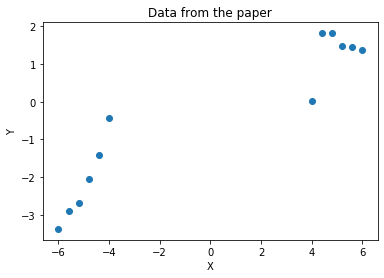

In [2]:
# visualize the data used in original paper
import pandas as pd
data = pd.read_csv('./example/HW7_data.csv')
x, y = data['x'].values, data['y'].values
plt.scatter(x, y)
plt.title('Data from the paper')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Fitting the Neural Network

In [44]:
z = np.vstack([x,x**2, x**3])

In [45]:
z.shape

(3, 12)

## Z shape = (3, 12)

In [56]:
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices

width = 5 #7
hidden_layers = 2 #2
input_dim = 3
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 127
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size': 1e-3, #1e-3
          'max_iteration': 2000, #5000
          'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=z, y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 46.16067289426424; gradient mag: 25.279668579097653
Iteration 100 lower bound 32.327810217164334; gradient mag: 70.37722720243066
Iteration 200 lower bound 27.103792414231226; gradient mag: 37.70285741996947
Iteration 300 lower bound 19.02762604919811; gradient mag: 29.485682259411107
Iteration 400 lower bound 9.121547456242412; gradient mag: 32.16668554014629
Iteration 500 lower bound 2.840406086482813; gradient mag: 14.890189544411854
Iteration 600 lower bound 1.1499982254275751; gradient mag: 5.590245531112483
Iteration 700 lower bound 0.7264148668445346; gradient mag: 2.443268573022149
Iteration 800 lower bound 0.6126989340606362; gradient mag: 1.1539610661395434
Iteration 900 lower bound 0.5819052753391627; gradient mag: 0.5719494326521372
Iteration 1000 lower bound 0.5724300458451806; gradient mag: 0.3268026006253102
Iteration 1100 lower bound 0.5683064431714904; gradient mag: 0.2324420834684601
Iteration 1200 lower bound 0.5658085823386096; gradient mag: 

In [57]:
z_test = np.vstack([x_test, x_test**2])
z_test.shape

(2, 1000)

Text(0, 0.5, 'Y')

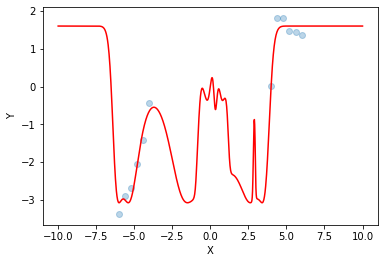

In [58]:
# visualize the model's prediction
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
z_test = np.vstack([x_test, x_test**2, x_test**3])
y_test = my_nn.forward(z_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y')



## W shape = (24,)

In [91]:
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices

width = 5 #7
hidden_layers = 1 #2
input_dim = 1
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 127
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size': 1e-3, #1e-3
          'max_iteration': 10000, #5000
          'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=w.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

ValueError: operands could not be broadcast together with shapes (1,12) (1,1,24) 

## HMC + Random Subspace

In [88]:
z.reshape(1,-1)

array([[-6.  , -5.6 , -5.2 , -4.8 , -4.4 , -4.  ,  4.  ,  4.4 ,  4.8 ,
         5.2 ,  5.6 ,  6.  , 36.  , 31.36, 27.04, 23.04, 19.36, 16.  ,
        16.  , 19.36, 23.04, 27.04, 31.36, 36.  ]])

In [11]:
my_nn.params['D_in']

2

In [12]:
### HMC + random
# set up model, subspace, inference

my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=z, y=y)
P, w = my_subspace.get_space()
hmc_tune_params={'step_size': 1e-2, #1e-2
                'leapfrog_steps': 20, #10
                'total_samples': 5000,
                'burn_in': 0.1,
                'warm_start': True,
                'thinning_factor': 1, #1
                'mom_std': 1, #1
                'diagnostic_mode': False}
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for HMC
my_inference.train(X=z, y=y, warm_start=True, position_init=position_init)

HMC 200: accept rate of 82.0 with step size 0.01
HMC 400: accept rate of 84.25 with step size 0.0105
HMC 200: accept rate of 82.0
HMC 400: accept rate of 81.25
HMC 600: accept rate of 81.16666666666667
HMC 800: accept rate of 80.125
HMC 1000: accept rate of 79.4
HMC 1200: accept rate of 79.91666666666667
HMC 1400: accept rate of 79.57142857142857
HMC 1600: accept rate of 79.5625
HMC 1800: accept rate of 79.55555555555556
HMC 2000: accept rate of 79.55
HMC 2200: accept rate of 79.63636363636364
HMC 2400: accept rate of 79.54166666666667
HMC 2600: accept rate of 80.15384615384616
HMC 2800: accept rate of 80.0
HMC 3000: accept rate of 80.16666666666667
HMC 3200: accept rate of 80.09375
HMC 3400: accept rate of 79.91176470588235
HMC 3600: accept rate of 79.83333333333333
HMC 3800: accept rate of 79.73684210526316
HMC 4000: accept rate of 79.7
HMC 4200: accept rate of 79.61904761904762
HMC 4400: accept rate of 79.63636363636364
HMC 4600: accept rate of 79.73913043478261
HMC 4800: accept rat

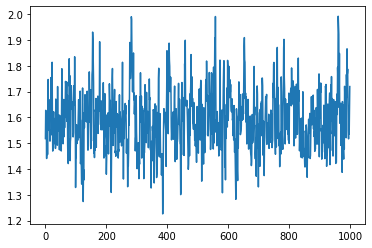

In [19]:
plt.plot(my_inference.get_posterior(1000)[:,0])


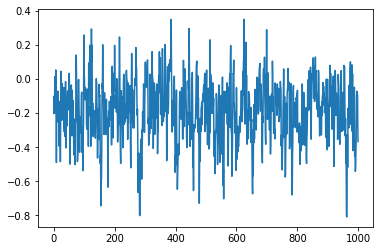

In [20]:
plt.plot(my_inference.get_posterior(1000)[:,1])

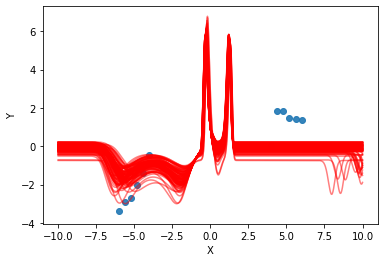

In [16]:
n = 100
z_samples = my_inference.get_posterior(n_samples = n)
for i in range(n):
    x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
    y_test = my_nn.forward(P=P, w_hat=w, z=z_samples[i], X = z_test)[0]
    
    plt.plot(x_test[0], y_test[0], color = 'red', alpha = 0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
plt.scatter(x, y, alpha = 0.9)

## HMC + PCA Subspace

In [30]:
### HMC + pca
# set up model, subspace, inference

my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=z, y=y)
P, w = my_subspace.get_space()
hmc_tune_params={'step_size': 1e-1, #1e-2
                'leapfrog_steps': 20, #10
                'total_samples': 10000,
                'burn_in': 0.1,
                'warm_start': True,
                'thinning_factor': 1, #1
                'mom_std': 1, #1
                'diagnostic_mode': False} #这里不管怎么调都不converge 
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for HMC
my_inference.train(X=z, y=y, warm_start=True, position_init=position_init)

HMC 200: accept rate of 78.5 with step size 0.1
HMC 400: accept rate of 78.5 with step size 0.1
HMC 600: accept rate of 76.83333333333333 with step size 0.1
HMC 800: accept rate of 77.0 with step size 0.1
HMC 200: accept rate of 76.5
HMC 400: accept rate of 79.25
HMC 600: accept rate of 77.66666666666667
HMC 800: accept rate of 77.5
HMC 1000: accept rate of 77.9
HMC 1200: accept rate of 77.58333333333333
HMC 1400: accept rate of 76.78571428571429
HMC 1600: accept rate of 77.0625
HMC 1800: accept rate of 76.94444444444444
HMC 2000: accept rate of 77.4
HMC 2200: accept rate of 77.54545454545455
HMC 2400: accept rate of 77.66666666666667
HMC 2600: accept rate of 77.57692307692308
HMC 2800: accept rate of 77.35714285714286
HMC 3000: accept rate of 77.26666666666667
HMC 3200: accept rate of 77.28125
HMC 3400: accept rate of 77.5
HMC 3600: accept rate of 77.63888888888889
HMC 3800: accept rate of 77.60526315789474
HMC 4000: accept rate of 77.525
HMC 4200: accept rate of 77.61904761904762
HMC

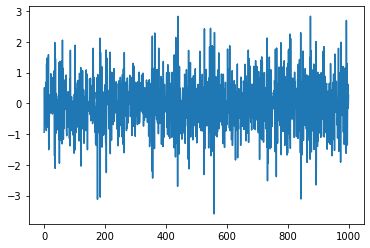

In [31]:
plt.plot(my_inference.get_posterior(1000)[:,0])

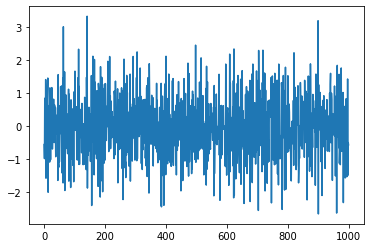

In [32]:
plt.plot(my_inference.get_posterior(1000)[:,1])

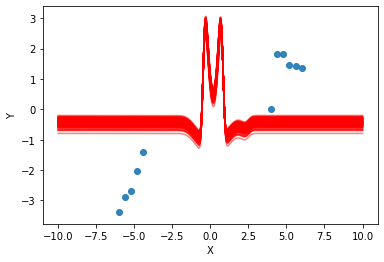

In [33]:
n = 100
z_samples = my_inference.get_posterior(n_samples = n)
for i in range(n):
    x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
    y_test = my_nn.forward(P=P, w_hat=w, z=z_samples[i], X = z_test)[0]
    
    plt.plot(x_test[0], y_test[0], color = 'red', alpha = 0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
plt.scatter(x, y, alpha = 0.9)

## BBB + Random Subspace

In [35]:
### BBVI + random
# set up model, subspace, inference

my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=z, y=y)
P, w = my_subspace.get_space()
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for BBB
my_inference.train(X=z, y=y, warm_start=True, position_init=position_init)

[0.38668005 0.33344219 0.17640523 0.04001572]
Iteration 0 lower bound -6515.375937886024; gradient mag: 1417.101154947281
[ 0.18977511  0.11600591 -0.29354434 -0.30858546]
Iteration 200 lower bound -6092.916031772577; gradient mag: 597.903981406689
[ 0.27526427 -0.11445235 -0.75247321 -0.67270365]
Iteration 400 lower bound -6067.282354344105; gradient mag: 1195.180893330898
[ 0.34455319  0.10960517 -1.17577162 -1.15621269]
Iteration 600 lower bound -5697.253003964888; gradient mag: 1180.534124433719
[ 0.32122808  0.0908955  -1.42946    -1.43073257]
Iteration 800 lower bound -5578.526628153725; gradient mag: 1001.4891719063229


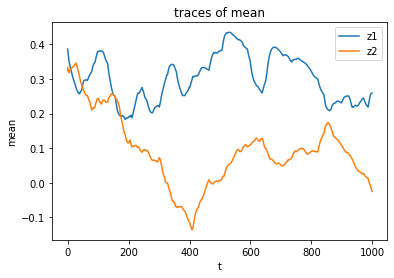

In [36]:
# extract mean and variance for 2 parameters
mean1 = my_inference.optimal_trace[:, 0]
mean2 = my_inference.optimal_trace[:, 1]
var1 = my_inference.optimal_trace[:, 2]
var2 = my_inference.optimal_trace[:, 3]

plt.plot(mean1, label = 'z1')
plt.plot(mean2, label = 'z2')
plt.title('traces of mean')
plt.xlabel('t')
plt.ylabel('mean')
plt.legend()
plt.show()

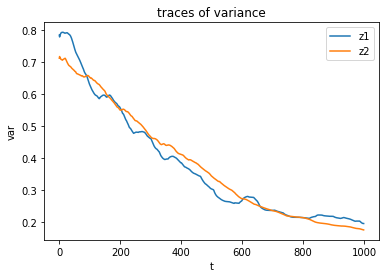

In [37]:
plt.plot(var1, label = 'z1')
plt.plot(var2, label = 'z2')
plt.title('traces of variance')
plt.xlabel('t')
plt.ylabel('var')
plt.legend()
plt.show()

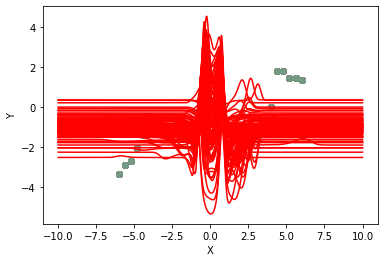

In [39]:
for i in range(100):
    z1_sample, z2_sample = np.random.multivariate_normal(my_inference.variational_mu, my_inference.variational_Sigma)

    y_test = my_nn.forward(P=P, w_hat=w, z=np.array([z1_sample, z2_sample]), X = z_test)[0]
    plt.scatter(x, y, alpha = 0.3)
    plt.plot(x_test[0], y_test[0], color = 'red')
    plt.xlabel('X')
    plt.ylabel('Y')

## BBB + PCA

In [40]:
### BBVI + random
# set up model, subspace, inference

my_subspace = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=z, y=y)
P, w = my_subspace.get_space()
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for BBB
my_inference.train(X=z, y=y, warm_start=True, position_init=position_init)

[ 3.08823978e+01 -3.32942000e-29  1.76405235e-01  4.00157208e-02]
Iteration 0 lower bound -5926.063842087094; gradient mag: 40.1346121470651
[28.92106722  0.42858256 -0.10465446 -0.77114271]
Iteration 200 lower bound -5852.84423929978; gradient mag: 35.84116402699089
[27.03795065  0.35121899 -0.25142156 -1.22429   ]
Iteration 400 lower bound -5787.724343937186; gradient mag: 34.62207540453079
[25.22987004  0.21746686 -0.32852058 -1.46306999]
Iteration 600 lower bound -5723.369796909674; gradient mag: 30.39833054125795
[ 2.34984704e+01  5.35072504e-03 -4.06918769e-01 -1.65418326e+00]
Iteration 800 lower bound -5677.635503952883; gradient mag: 28.787978063052282


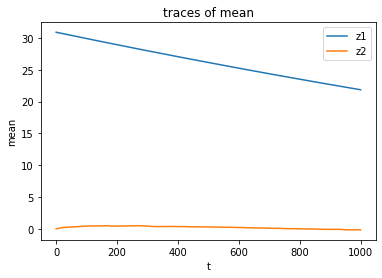

In [41]:
# extract mean and variance for 2 parameters
mean1 = my_inference.optimal_trace[:, 0]
mean2 = my_inference.optimal_trace[:, 1]
var1 = my_inference.optimal_trace[:, 2]
var2 = my_inference.optimal_trace[:, 3]

plt.plot(mean1, label = 'z1')
plt.plot(mean2, label = 'z2')
plt.title('traces of mean')
plt.xlabel('t')
plt.ylabel('mean')
plt.legend()
plt.show()

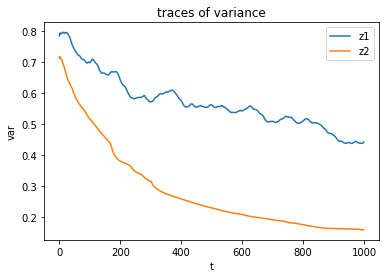

In [42]:
plt.plot(var1, label = 'z1')
plt.plot(var2, label = 'z2')
plt.title('traces of variance')
plt.xlabel('t')
plt.ylabel('var')
plt.legend()
plt.show()

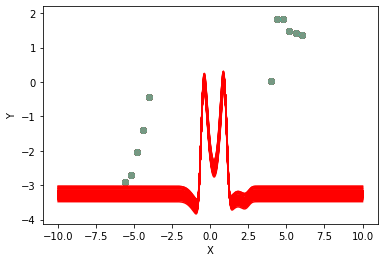

In [43]:
for i in range(100):
    z1_sample, z2_sample = np.random.multivariate_normal(my_inference.variational_mu, my_inference.variational_Sigma)

    y_test = my_nn.forward(P=P, w_hat=w, z=np.array([z1_sample, z2_sample]), X = z_test)[0]
    plt.scatter(x, y, alpha = 0.3)
    plt.plot(x_test[0], y_test[0], color = 'red')
    plt.xlabel('X')
    plt.ylabel('Y')

# Curve Subspace + HMC

In [1]:
import src.util
import src.CurveSubspace as curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt
from autograd import numpy as np


from src.Inference import Inference
from src.Subspace import Subspace
from src.model import Model
from src.util import hidecode
import random


# visualize the data used in original paper
import pandas as pd
data = pd.read_csv('./example/HW7_data.csv')
x, y = data['x'].values, data['y'].values

In [2]:
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices

width = 5 #7
hidden_layers = 1 #2
input_dim = 1
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 127
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size': 1e-3, #1e-3
          'max_iteration': 5000, #5000
          'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.11668053773148; gradient mag: 164.73210946091572
Iteration 100 lower bound 52.864360467566954; gradient mag: 56.95458639088454
Iteration 200 lower bound 49.42633385370296; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.733261895623144; gradient mag: 18.311751879565843
Iteration 400 lower bound 46.64774569354082; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.886915428058316; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.977925085924852; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665738; gradient mag: 18.779125916898227
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.210455188665925
Iteration 1200 lower bound 18.43436747168103; gradient mag: 15.09

Text(0, 0.5, 'Y')

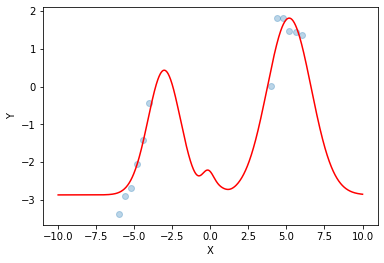

In [5]:
# visualize the model's prediction
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y')

In [4]:

net = curve.BaseNet(1, width, hidden_layers)

optimizer = optim.Adam(net.parameters(), lr = 0.1)
criterion = nn.MSELoss()

dataset = TensorDataset(torch.Tensor(x.reshape(-1, 1)), torch.Tensor(y))
loader = DataLoader(dataset, batch_size=64, shuffle = True)

# for training the two endpoints
params_base = {'epochs': 1000}

def CurveNetGen(w0, w1):
    return curve.CurveNet(1, width, hidden_layers, w0, w1)

# for training the mid-points
params_curve = {'epochs':300, 'sample_size': 500}

my_subspace = Subspace.create(subspace_type="curve", net = net, loader = loader, params_base = params_base, 
                           optimizer = optimizer, criterion = criterion, 
                           curve_net_gen = CurveNetGen, params_curve = params_curve)

# change callback to control printin frequency (0 = no printing)
my_subspace.collect_vector(epochs = 300, callback = 20)
P, w = my_subspace.get_space()

/Users/ZiyiZ/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[epoch 1] loss: 0.206
[epoch 21] loss: 0.202
[epoch 41] loss: 0.199
[epoch 61] loss: 0.196
[epoch 81] loss: 0.194
[epoch 101] loss: 0.192
[epoch 121] loss: 0.191
[epoch 141] loss: 0.189
[epoch 161] loss: 0.188
[epoch 181] loss: 0.188
[epoch 201] loss: 0.187
[epoch 221] loss: 0.186
[epoch 241] loss: 0.186
[epoch 261] loss: 0.186
[epoch 281] loss: 0.185


Text(0.5, 1.0, 'w')

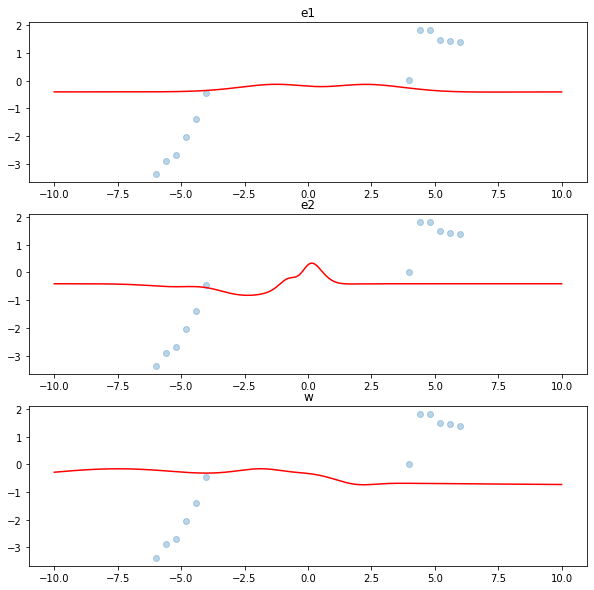

In [8]:
# visualize the model's prediction
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test_e1 = my_nn.forward(x_test, use_subweights = False, weights = my_subspace.e1.reshape(1, -1))[0]
y_test_e2 = my_nn.forward(x_test, use_subweights = False, weights = my_subspace.e2.reshape(1, -1))[0]
y_test_w = my_nn.forward(x_test, use_subweights = False, weights =  w.reshape(1, -1))[0]

plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test_e1[0], color = 'red')
plt.title('e1')

plt.subplot(3,1,2)
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test_e2[0], color = 'red')
plt.title('e2')

plt.subplot(3,1,3)
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test_w[0], color = 'red')
plt.title('w')



In [ ]:
### HMC + curve
# set up model, subspace, inference

hmc_tune_params={'step_size': 0.2, #1e-2
                'leapfrog_steps': 20, #10
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 3, #1
                'mom_std': 1, #1
                'diagnostic_mode': False}
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params)


# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=P, w_hat=w)

# train
# for HMC
my_inference.train(X=x, y=y, warm_start=True, position_init=position_init)

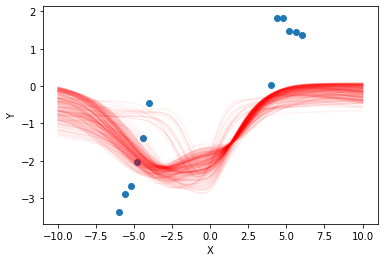

In [12]:
n = 200
z_samples = my_inference.get_posterior(n_samples = n)
for i in range(n):
    x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
    y_test = my_nn.forward(P=P, w_hat=w, z=z_samples[i], X = x_test)[0]
    plt.plot(x_test[0], y_test[0], color = 'red', alpha = 0.05)
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(x, y)

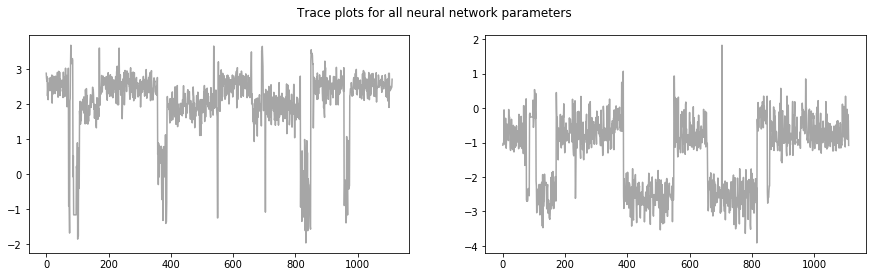

In [13]:
post_sample=my_inference.get_posterior(n_samples=10000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()

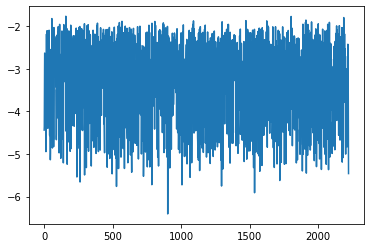

In [79]:
plt.plot(my_inference.get_posterior(20000)[:,0])

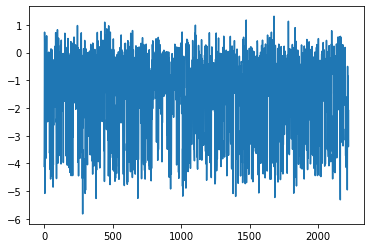

In [80]:
plt.plot(my_inference.get_posterior(20000)[:,1])